In [1]:
%matplotlib inline
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
train = pd.read_csv('src/train.csv')

In [3]:
train.drop("Id", axis=1, inplace=True)

# Data Exploration

In [4]:
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 80 entries, MSSubClass to SalePrice
dtypes: float64(3), int64(34), object(43)
memory usage: 912.6+ KB


## Let´s start analysing the target

In [5]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

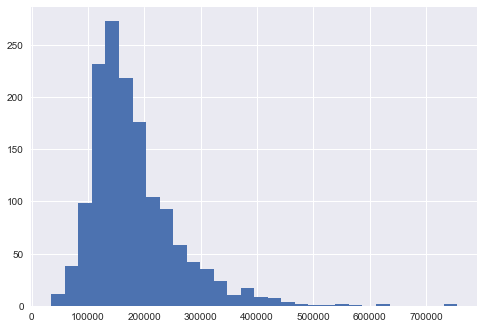

In [6]:
train['SalePrice'].hist(bins=30).plot()
plt.show()

The distribution is right skewed. Usually a log transformation is sufficient to transform this in a normal distribution. To clarify a bit more, we will follow with a Probability Plot

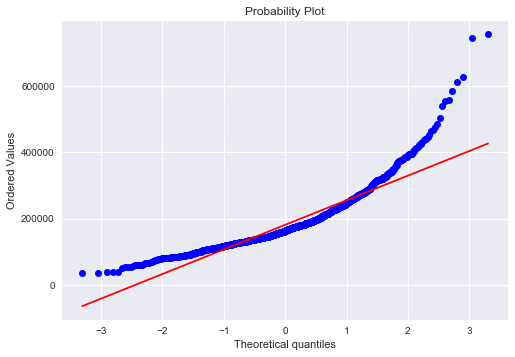

In [7]:
stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Although earlier we verified that there is no price that is either negative or zero, we could continue with a simple log transformation, but we will use a log(1+x) to make the solution safer

In [8]:
train["SalePrice"] = np.log1p(train["SalePrice"])
# It's important to remember that log(1 + x), the inverse of expm1.

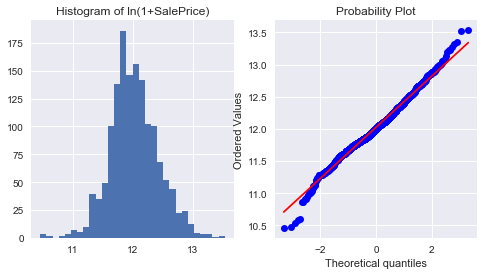

In [9]:
sns.set(rc={'figure.figsize':(8,4)})
plt.subplot(1, 2, 1)
train['SalePrice'].hist(bins=30).plot()
plt.title("Histogram of ln(1+SalePrice)")
plt.subplot(1, 2, 2)
stats.probplot(train['SalePrice'], plot=plt)
plt.show()

As we can see above, after the transformation the target is almost normal

## Now it's time to look a bit closer on correlations

Before diving deeper on correlation, let´s take a look at the different lists of variable's labels that we will create

In [10]:
high_correlation = [] #For variables that are highly correlated with the target
remove_multicolinearity = [] #Variables that will be removed from the model because of multicolinearity
add_multicolinearity = [] # Variables that will be kept after eliminating the multicolinearity problem
add_categorical = [] # Categorical variables to be used on the model
remove_categorical = [] # Categorical variables that will not be usued on the model
remove_null = [] # Variables that will be removed due to high frequency of nulls

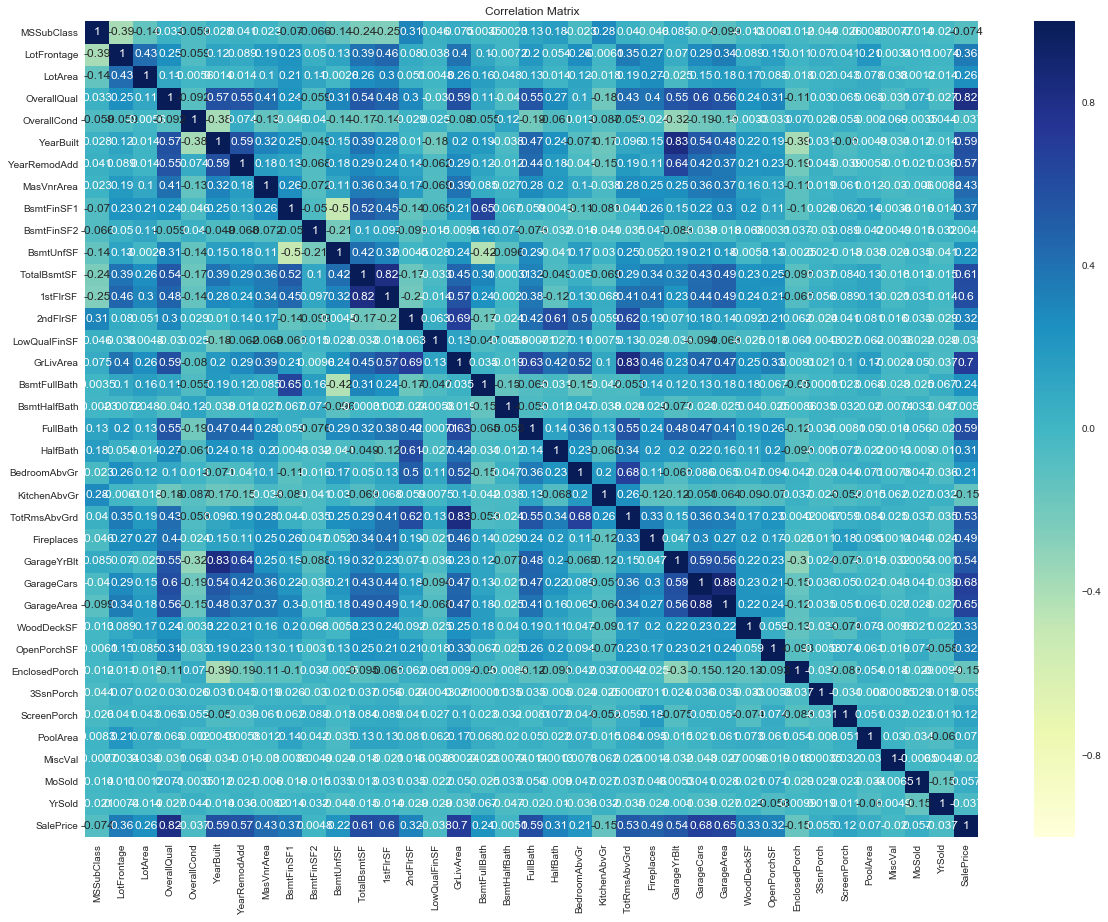

In [11]:
plt.subplots(figsize=(20,15))
sns.heatmap(train.corr(), cmap="YlGnBu", annot=True)
plt.title("Correlation Matrix")
plt.show()

The correlation plot above was created only to have an idea of correlation between variables. Although we have some interesting correlations that needs to be investigated deeper, at this moment we will focus the investigation on the variables that are highly correlated with the SalesPrice.
* OverallQual
* TotalBsmtSF
* GrLivArea
* GarageCars

In [12]:
temp = train.loc[:,['OverallQual','TotalBsmtSF','GrLivArea','GarageCars', 'SalePrice']]

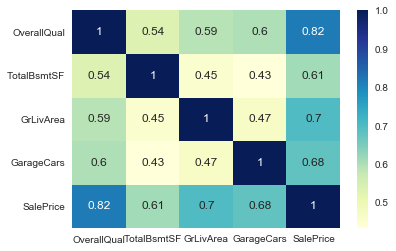

In [13]:
plt.subplots(figsize=(6,4))
sns.heatmap(temp.corr(), cmap="YlGnBu", annot=True)
plt.show()

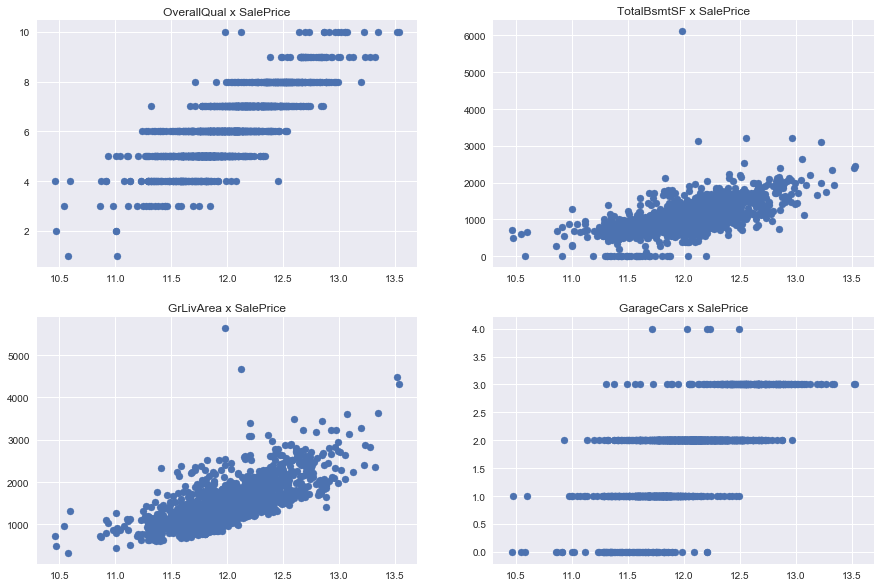

In [14]:
colunas = list(temp.columns)
colunas.remove('SalePrice')

plt.subplots(figsize=(15,10))
for n, coluna in enumerate(colunas):
    plt.subplot(2,2,n+1)
    plt.title(coluna + " x SalePrice")
    plt.scatter(x=temp['SalePrice'], y=temp[coluna])
    
plt.show()

**OverallQual:** This numerical variable will be transformed to an ordered categorical variable. But  it´s interesting to note that it has an almost linear correlation with the price

**TotalBsmtSF** This variable has a positive relationship with price. There is an interesting outlier that is a building with a very big basement, but I will keep it

**GrLivArea** and **GarageCars** are very correlated with the price as well with no outlier to be removed

From the above, only OverallQual and GarageCars are in my list of High Importance vars on "variable_description.xlsx" file. It´s important to mention that I ranked the variables in the spreadsheet prior to analysing the data, so it's only a personal feeling on the variable importance.

In [15]:
# Convert to Ordered Category
train["OverallQual"]=train["OverallQual"].astype('category', ordered=True, categories=[1,2,3,4,5,6,7,8,9,10])

In [16]:
# Adding variables to the respective lists
high_correlation.extend(['TotalBsmtSF','GrLivArea','GarageCars'])
add_categorical.append('OverallQual')

### From now on we will analyze all pairs of variables that have correlation greater than 0.8 because they can bring multicolinearity problems to the model

In [17]:
#GarageArea Vs GarageCars, 
#GarageCars has a bigger correlation with the target
remove_multicolinearity.append("GarageArea")

In [18]:
# YearBuilt has a bigger correlation with the target
add_multicolinearity.append("YearBuilt")
remove_multicolinearity.append("GarageYrBlt")

In [19]:
#GrLivArea Vs TotRmsAbvGrd
#GrLivArea has a bigger correlation with the target
remove_multicolinearity.append("TotRmsAbvGrd")

In [20]:
#1stFlrSF Vs TotalBsmtSF
#TotalBsmtSF has a bigger correlation with the target
remove_multicolinearity.append("1stFlrSF")

In [21]:
remove_multicolinearity

['GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF']

#### Converting Numerical to Categorical

In [22]:
train["MSSubClass"]=train["MSSubClass"].astype('category', ordered=False)
train["OverallCond"]=train["OverallCond"].astype('category', ordered=True, categories=[1,2,3,4,5,6,7,8,9,10])
train["MoSold"]=train["MoSold"].astype('category', ordered=True, categories=[1,2,3,4,5,6,7,8,9,10,11,12])

In [23]:
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 80 entries, MSSubClass to SalePrice
dtypes: category(4), float64(4), int64(29), object(43)
memory usage: 874.6+ KB


## Before advancing to categorical variables, let´s take a look at nulls

### List of columns with nulls

In [24]:
train.columns[train.isnull().sum()>0].tolist()

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

#### The graph below shows bars with the number of no null observations per variable. We will present only the variables that have at least 1 null observation

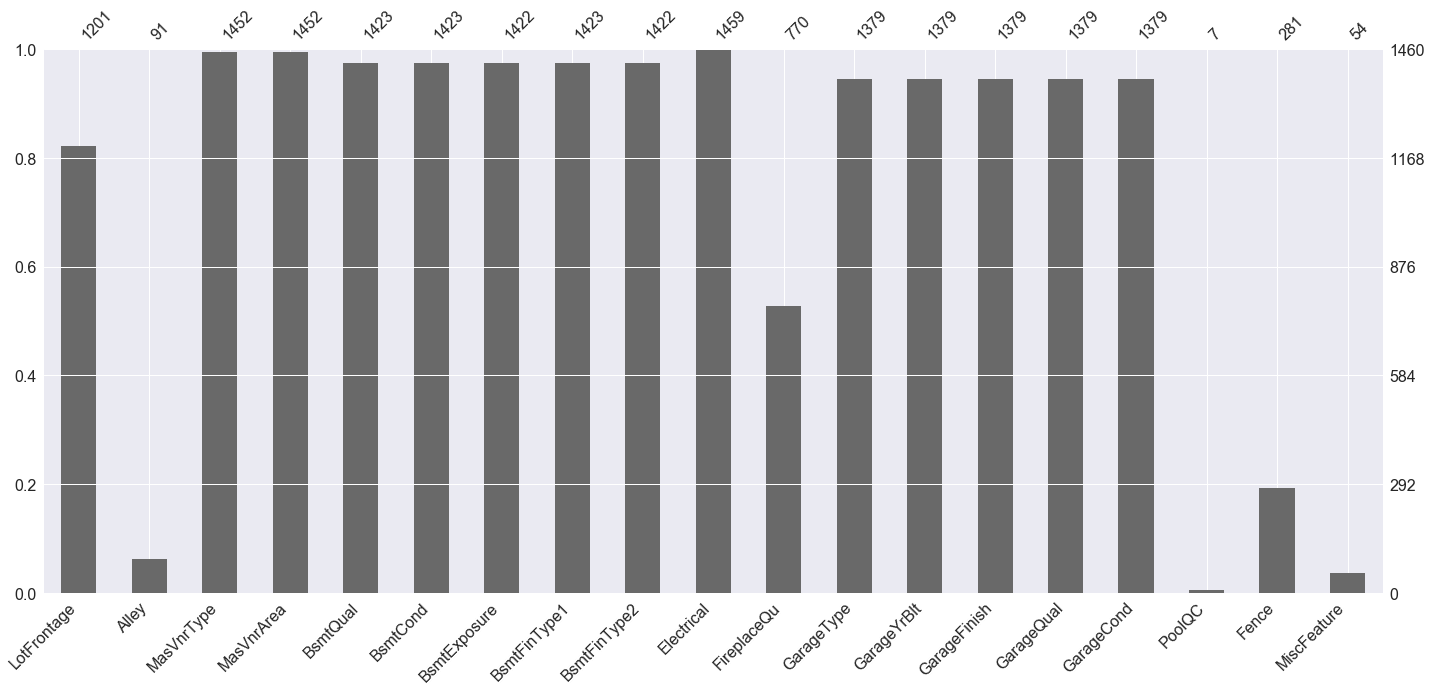

In [25]:
msno.bar(train.loc[:,train.columns[train.isnull().sum()>0].tolist()])

According to the data_description file, some nulls makes sense, so we will analyze them one by one, starting with the ones that we know what to do with

In [26]:
# Alley : NA means No Alley access
train["Alley"].fillna("No Alley", inplace=True)

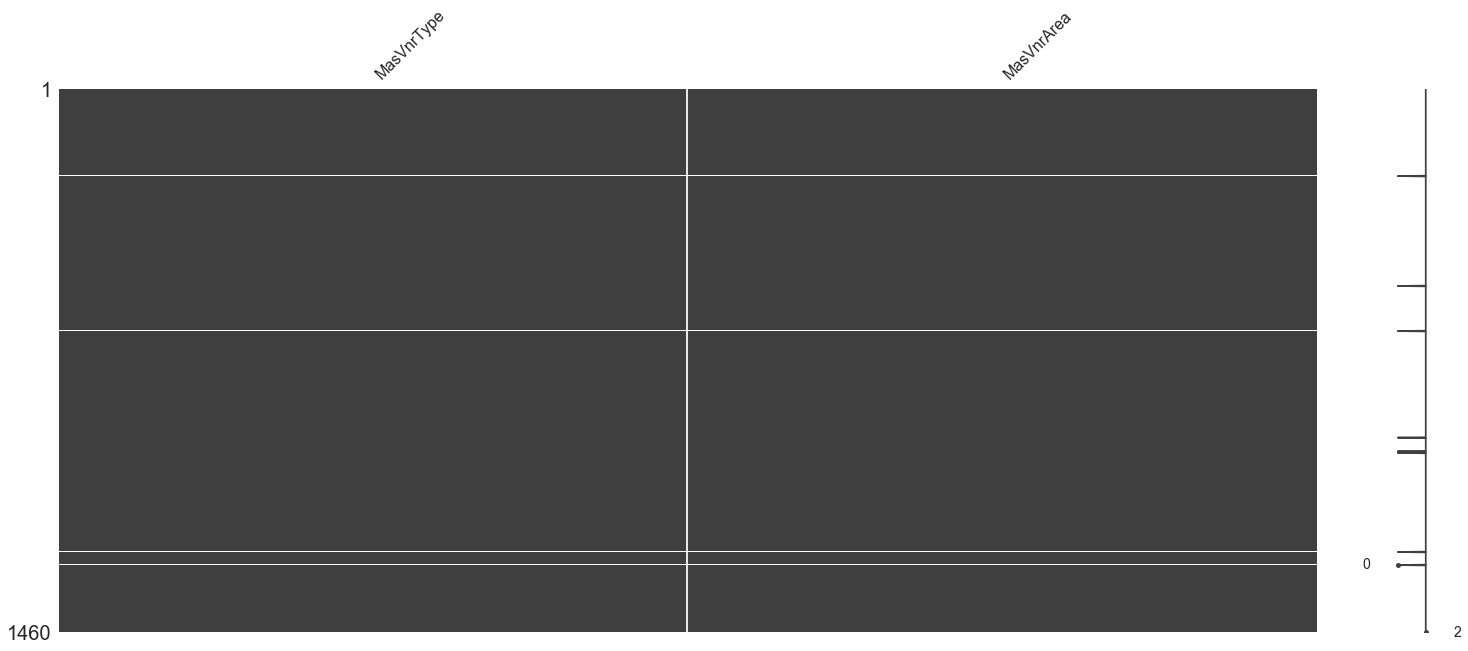

In [27]:
# MasVnrType and MasVnrArea have exactly the same amount of nulls. I will check if they are the same observations. If so, they will be dropped
msno.matrix(train.loc[:,["MasVnrType", "MasVnrArea"]])

As they have exactly the same observations null, they will be dropped

In [28]:
train.dropna(axis=0,subset=["MasVnrType"], inplace=True)

In [29]:
train.reset_index(drop=True, inplace=True)

In [30]:
# BsmtQual : NA means No basement
train["BsmtQual"].fillna("No Basement", inplace=True)

In [31]:
# BsmtCond : NA means No basement
train["BsmtCond"].fillna("No Basement", inplace=True)

In [32]:
# BsmtExposure : NA means No basement
train["BsmtExposure"].fillna("No Basement", inplace=True)

In [33]:
#  BsmtFinType1 : NA means No basement
train["BsmtFinType1"].fillna("No Basement", inplace=True)

In [34]:
#  BsmtFinType2 : NA means No basement
train["BsmtFinType2"].fillna("No Basement", inplace=True)

In [35]:
#Electrical have only 1 missing value so I will replace with the most common
train["Electrical"].value_counts()

SBrkr    1326
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [36]:
train["Electrical"].fillna("SBrkr", inplace=True)

In [37]:
#FireplaceQu : NA means No fireplace
train["FireplaceQu"].fillna("No fireplace", inplace=True)

In [38]:
#GarageType : NA means No garage
train["GarageType"].fillna("No garage", inplace=True)

In [39]:
#GarageFinish : NA means No garage
train["GarageFinish"].fillna("No garage", inplace=True)

In [40]:
#GarageQual : NA means No garage
train["GarageQual"].fillna("No garage", inplace=True)

In [41]:
#GarageCond : NA means No garage
train["GarageCond"].fillna("No garage", inplace=True)

In [42]:
#PoolQC : NA means No pool
train["PoolQC"].fillna("No pool", inplace=True)

In [43]:
#Fence : NA means No fence
train["Fence"].fillna("No fence", inplace=True)

In [44]:
#MiscFeature : NA means None
train["MiscFeature"].fillna("None", inplace=True)

In [45]:
#LotFrontage : Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [46]:
#LGarageYrBlt : As we can see below, all garages that do not have a Year Built, does not exist (has 0 size in cars)
train.loc[train["GarageYrBlt"].isnull(),["GarageYrBlt", "GarageCars"]]["GarageCars"].sum()

0

In [47]:
#LGarageYrBlt : Based on the above, we will fill nulls with 0
train["GarageYrBlt"].fillna(0, inplace=True)

# CONTINUAR DAQUI

## Time to analyze categorical data

### Starting with the ones that I have high expectation

In [86]:
def categorical_analizator(x,y,data,order=None):
    sns.set(rc={'figure.figsize':(10,5)})
    plt.subplot(1, 2, 1)
    sns.boxplot(x=x, y=y, 
                order=order,
                data=data, saturation=0.6)
    plt.title("Boxplot " + y + " Vs " + x)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    sns.countplot(x=x,data=data)
    plt.title("Count of "+x)
    plt.xlabel(x)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    plt.show()

In [49]:
def boxplotator(x,y,data,order=None,title="",xlabel="",ylabel=""):
    sns.boxplot(x=x, y=y, 
                order=order,
                data=data, saturation=0.6)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

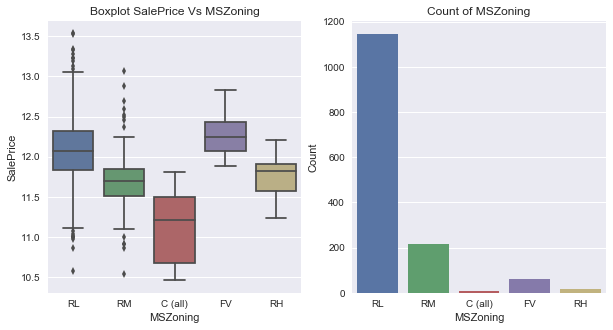

In [82]:
y="SalePrice"
x="MSZoning"
categorical_analizator(x=x, y=y, data=train)

Commercial have lower prices than others. Residential Low Density and fluvial have slightly higher prices

In [60]:
add_categorical.append(x)

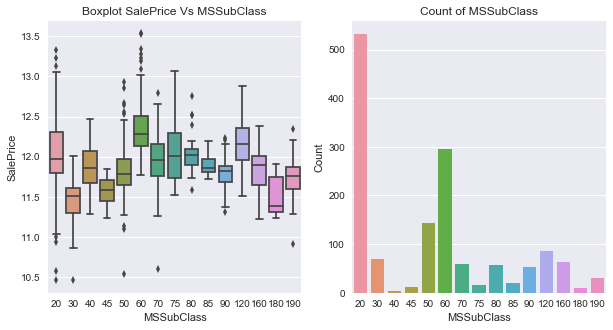

In [83]:
y="SalePrice"
x="MSSubClass"
categorical_analizator(x=x, y=y, data=train)

In [62]:
add_categorical.append(x)

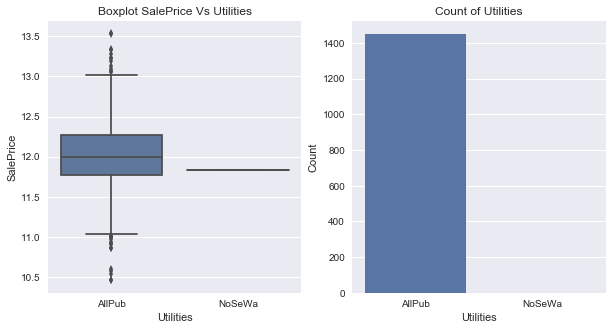

In [84]:
y="SalePrice"
x="Utilities"
categorical_analizator(x=x, y=y, data=train)

This categorical have a high concentration on only one category so it will be removed

In [65]:
remove_categorical.append("Utilities")

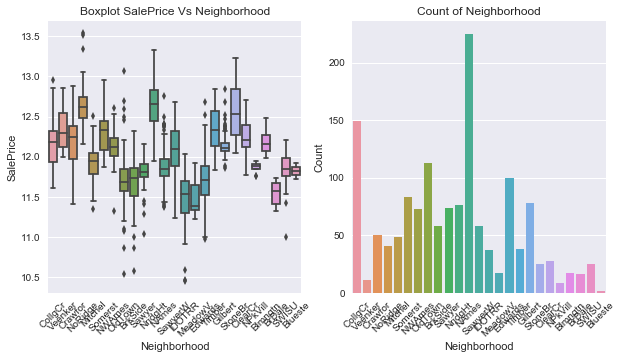

In [87]:
y="SalePrice"
x="Neighborhood"
categorical_analizator(x=x, y=y, data=train)

As expected some Neighborhoods have higher/lower prices

In [67]:
add_categorical.append(x)

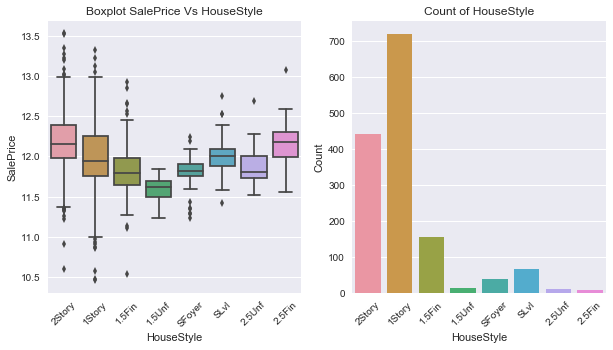

In [88]:
y="SalePrice"
x="HouseStyle"
categorical_analizator(x=x, y=y, data=train)

In [71]:
add_categorical.append(x)

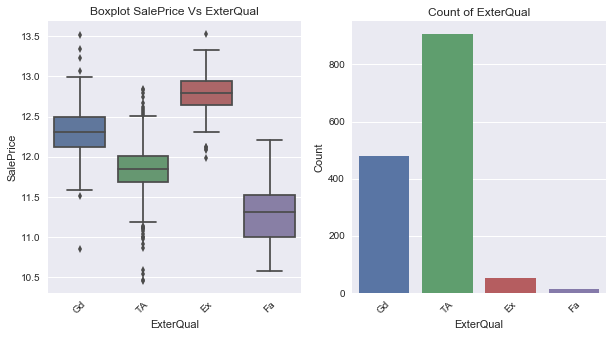

In [89]:
y="SalePrice"
x="ExterQual"
categorical_analizator(x=x, y=y, data=train)

In [73]:
add_categorical.append(x)

### Now we will analyze the ones that I have medium expectation

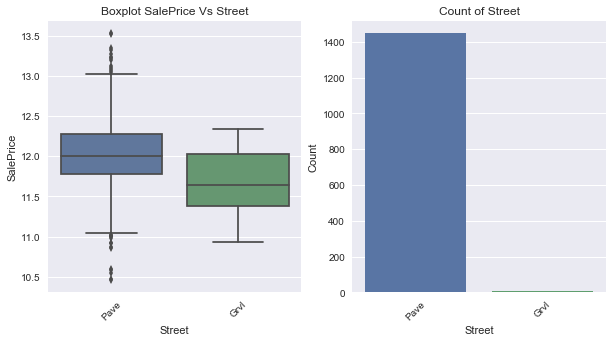

In [90]:
y="SalePrice"
x="Street"
categorical_analizator(x=x, y=y, data=train)

This categorical have a high concentration on only one category so it will be removed

In [76]:
remove_categorical.append(x)

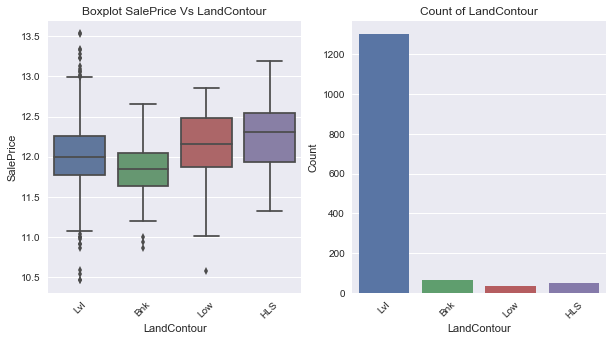

In [92]:
x="LandContour"
categorical_analizator(x=x, y=y, data=train)

In [93]:
add_categorical.append(x)

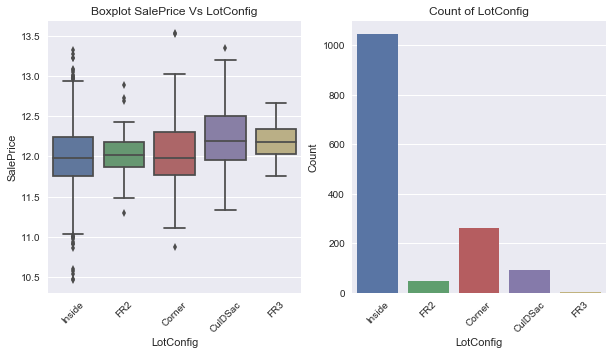

In [94]:
x="LotConfig"
y="SalePrice"
categorical_analizator(x=x, y=y, data=train)

In [95]:
add_categorical.append(x)

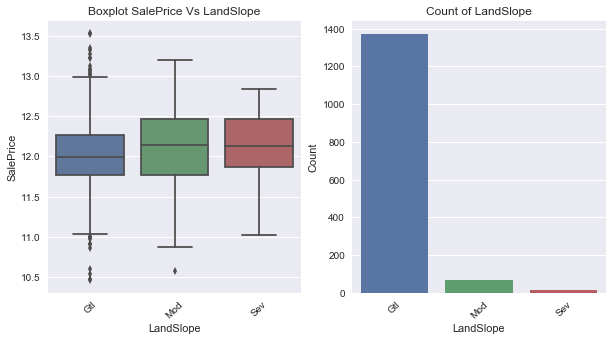

In [96]:
x="LandSlope"
categorical_analizator(x=x, y=y, data=train)

In [97]:
add_categorical.append(x)

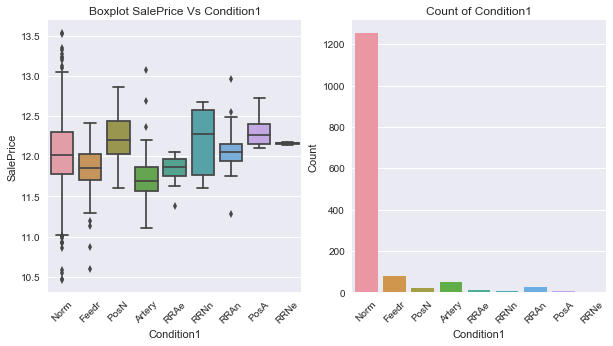

In [98]:
x="Condition1"
categorical_analizator(x=x, y=y, data=train)

In [99]:
add_categorical.append(x)

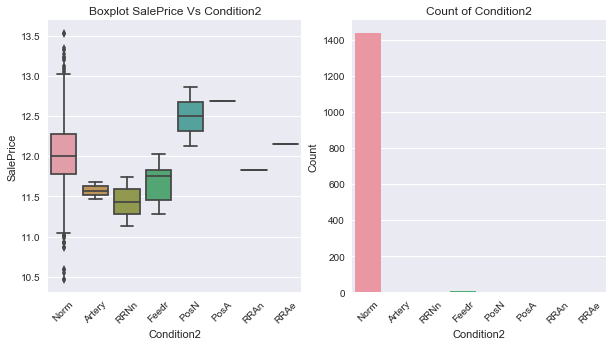

In [100]:
x="Condition2"
categorical_analizator(x=x, y=y, data=train)

In [101]:
remove_categorical.append(x)

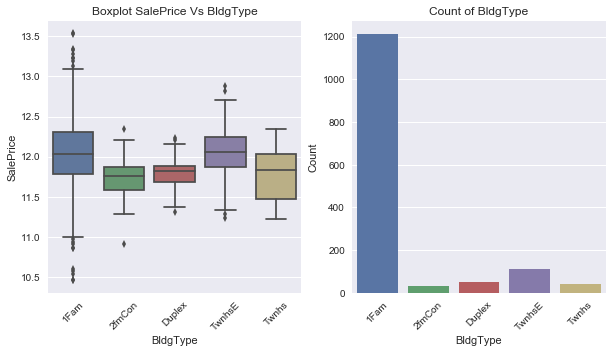

In [102]:
x="BldgType"
categorical_analizator(x=x, y=y, data=train)

In [103]:
add_categorical.append(x)

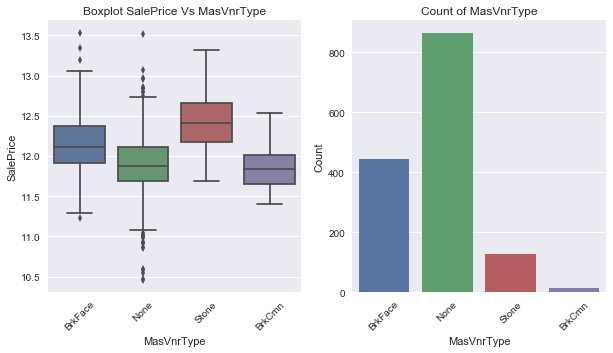

In [104]:
x="MasVnrType"
categorical_analizator(x=x, y=y, data=train)

In [105]:
add_categorical.append(x)

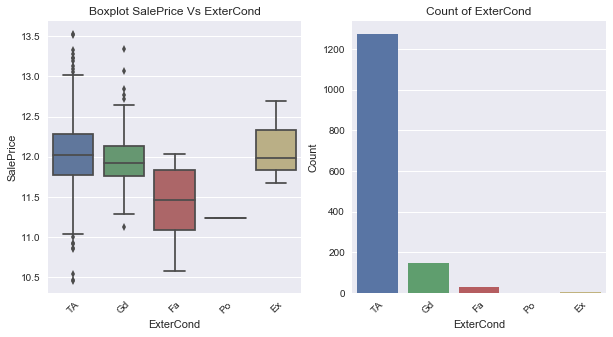

In [106]:
x="ExterCond"
categorical_analizator(x=x, y=y, data=train)

In [107]:
add_categorical.append(x)

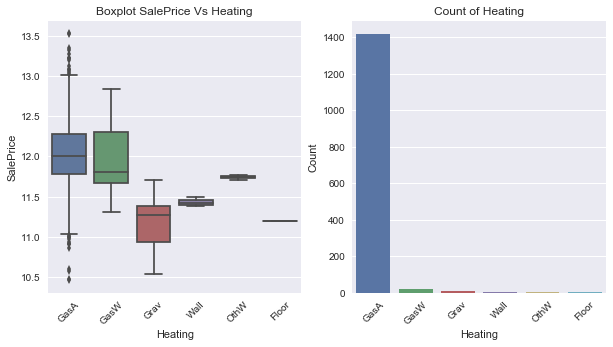

In [108]:
x="Heating"
categorical_analizator(x=x, y=y, data=train)

In [109]:
add_categorical.append(x)

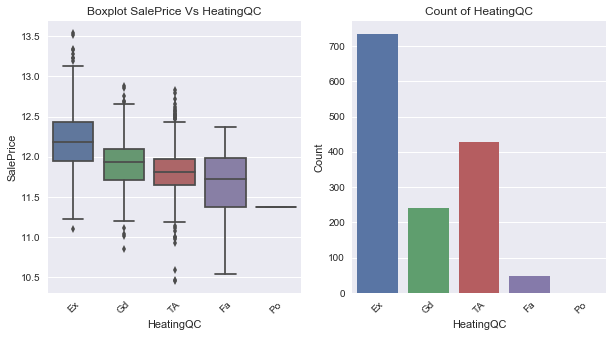

In [110]:
x="HeatingQC"
categorical_analizator(x=x, y=y, data=train)

In [111]:
add_categorical.append(x)

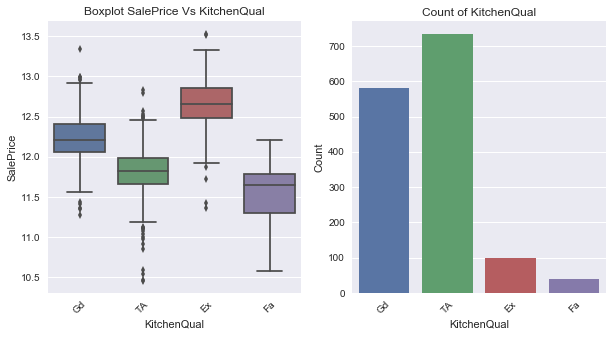

In [112]:
x="KitchenQual"
categorical_analizator(x=x, y=y, data=train)

In [113]:
add_categorical.append(x)

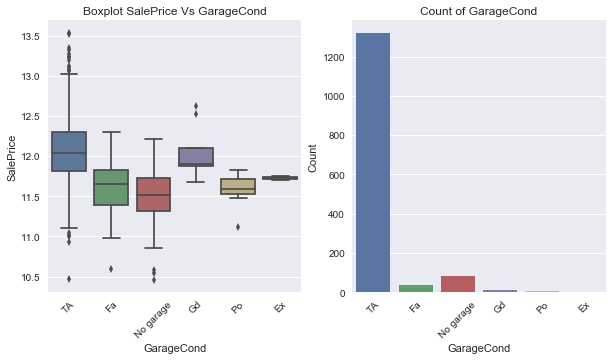

In [114]:
x="GarageCond"
categorical_analizator(x=x, y=y, data=train)

In [115]:
add_categorical.append(x)

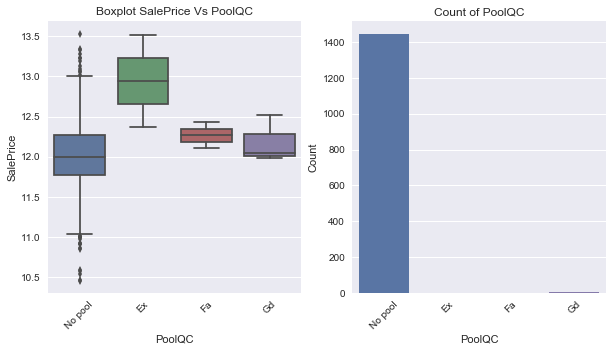

In [116]:
x="PoolQC"
categorical_analizator(x=x, y=y, data=train)

In [117]:
remove_categorical.append(x)

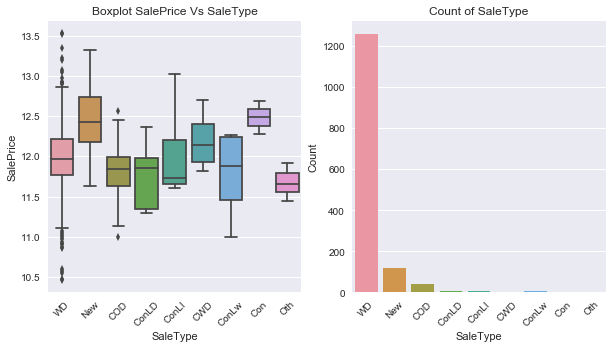

In [118]:
x="SaleType"
categorical_analizator(x=x, y=y, data=train)

In [119]:
add_categorical.append(x)

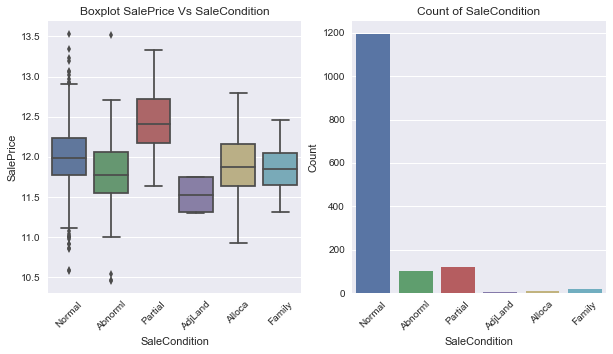

In [120]:
x="SaleCondition"
categorical_analizator(x=x, y=y, data=train)

In [121]:
add_categorical.append(x)

### Now it´s time for the low expectation

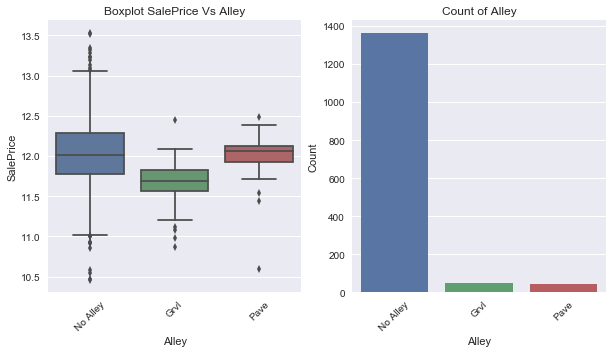

In [122]:
x="Alley"
categorical_analizator(x=x, y=y, data=train)

In [123]:
add_categorical.append(x)

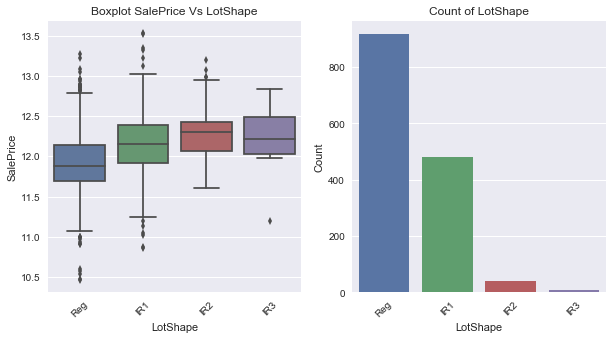

In [124]:
x="LotShape"
categorical_analizator(x=x, y=y, data=train)

In [125]:
add_categorical.append(x)

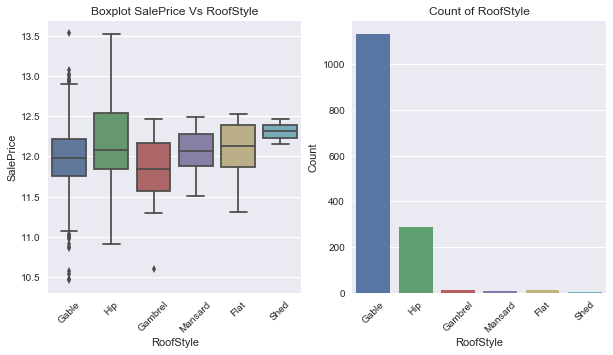

In [126]:
x="RoofStyle"
categorical_analizator(x=x, y=y, data=train)

In [127]:
add_categorical.append(x)

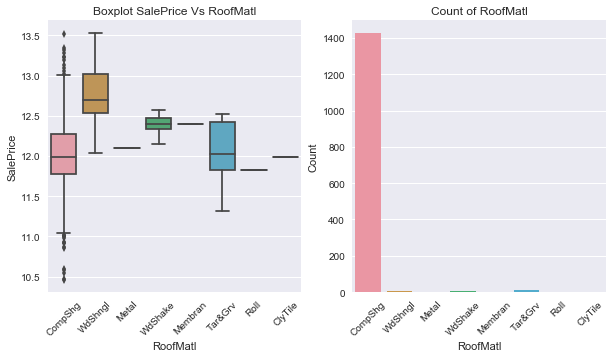

In [128]:
x="RoofMatl"
categorical_analizator(x=x, y=y, data=train)

In [129]:
add_categorical.append(x)

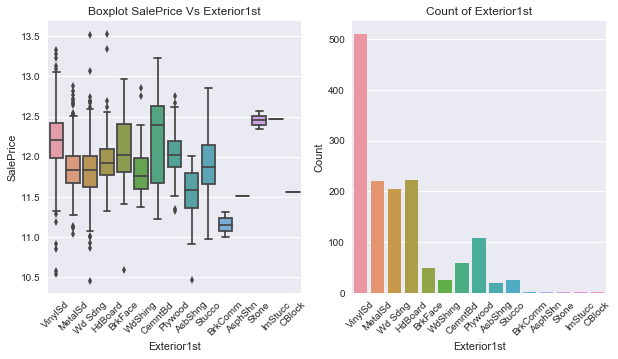

In [130]:
x="Exterior1st"
categorical_analizator(x=x, y=y, data=train)

In [131]:
add_categorical.append(x)

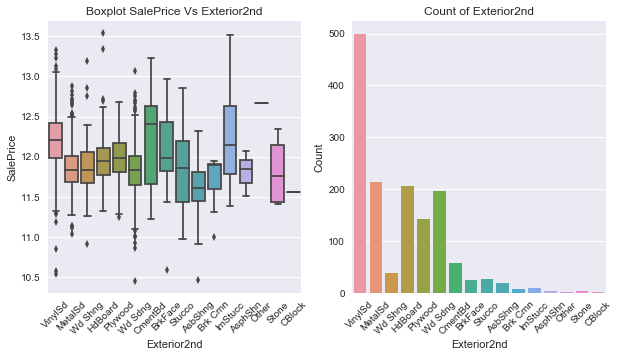

In [132]:
x="Exterior2nd"
categorical_analizator(x=x, y=y, data=train)

In [133]:
add_categorical.append(x)

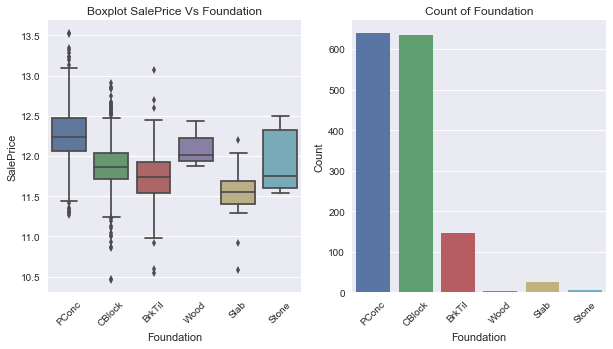

In [134]:
x="Foundation"
categorical_analizator(x=x, y=y, data=train)

In [135]:
add_categorical.append(x)

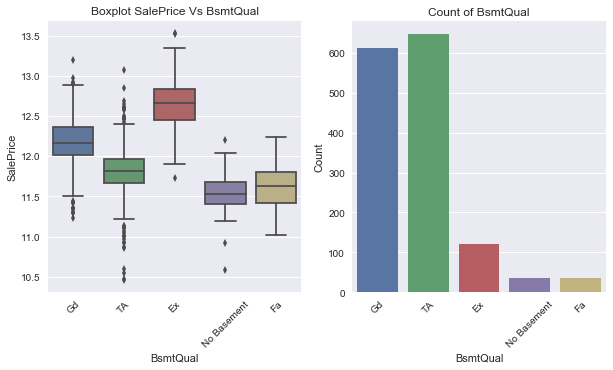

In [136]:
x="BsmtQual"
categorical_analizator(x=x, y=y, data=train)

In [137]:
add_categorical.append(x)

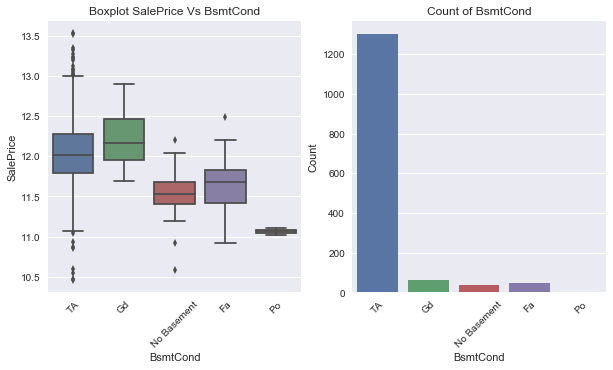

In [138]:
x="BsmtCond"
categorical_analizator(x=x, y=y, data=train)

In [139]:
add_categorical.append(x)

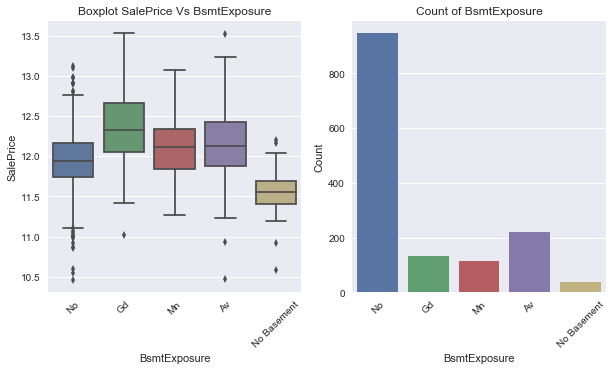

In [140]:
x="BsmtExposure"
categorical_analizator(x=x, y=y, data=train)

In [141]:
add_categorical.append(x)

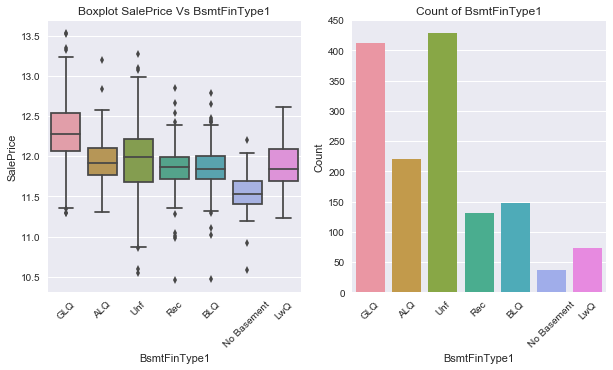

In [142]:
x="BsmtFinType1"
categorical_analizator(x=x, y=y, data=train)

In [143]:
add_categorical.append(x)

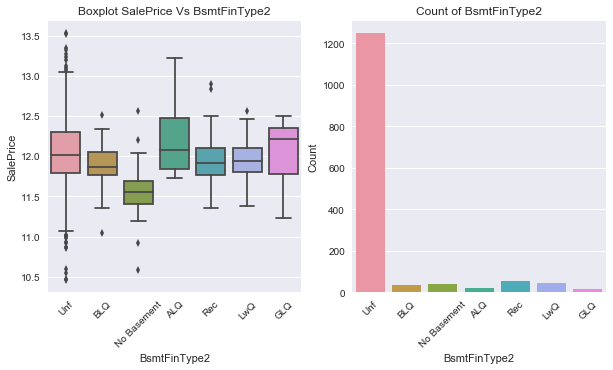

In [144]:
x="BsmtFinType2"
categorical_analizator(x=x, y=y, data=train)

In [145]:
add_categorical.append(x)

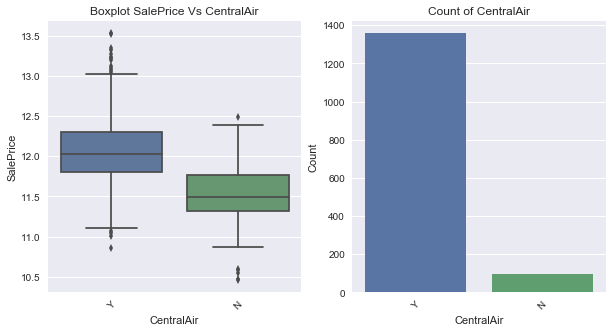

In [146]:
x="CentralAir"
categorical_analizator(x=x, y=y, data=train)

In [147]:
add_categorical.append(x)

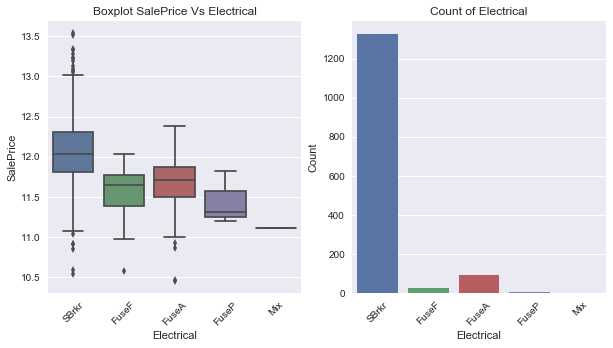

In [148]:
x="Electrical"
categorical_analizator(x=x, y=y, data=train)

In [149]:
add_categorical.append(x)

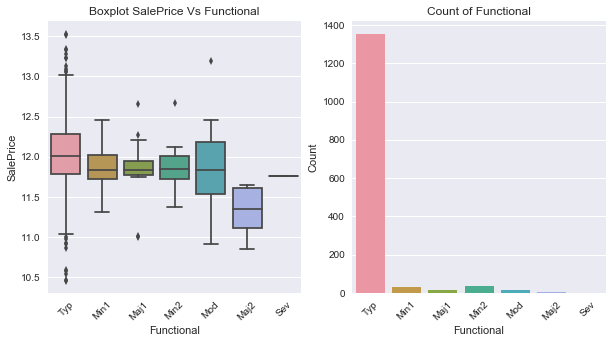

In [150]:
x="Functional"
categorical_analizator(x=x, y=y, data=train)

In [151]:
add_categorical.append(x)

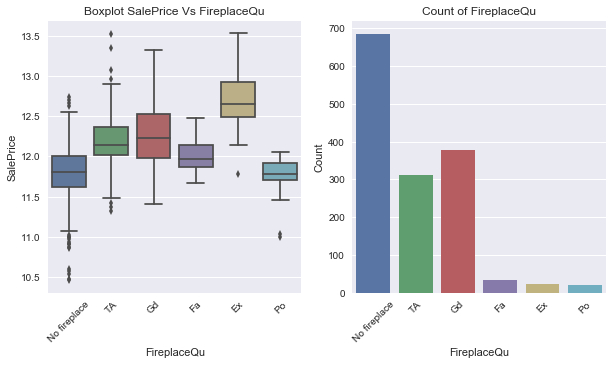

In [152]:
x="FireplaceQu"
categorical_analizator(x=x, y=y, data=train)

In [153]:
add_categorical.append(x)

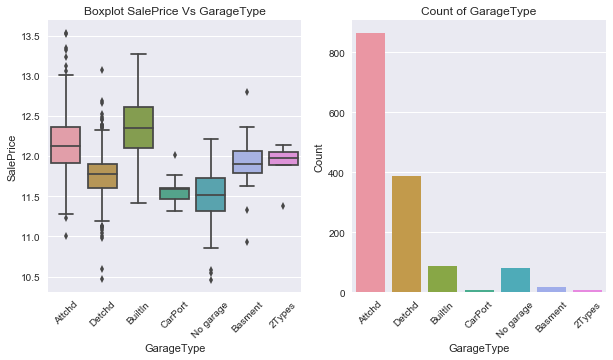

In [154]:
x="GarageType"
categorical_analizator(x=x, y=y, data=train)

In [155]:
add_categorical.append(x)

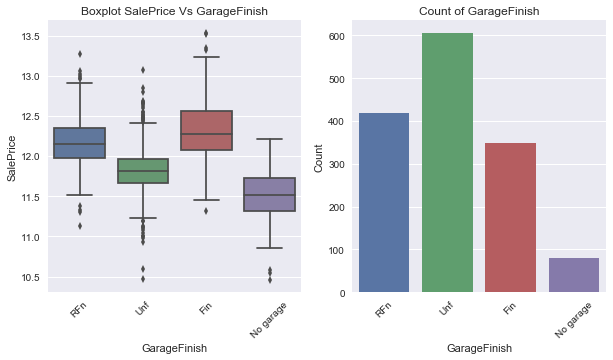

In [156]:
x="GarageFinish"
categorical_analizator(x=x, y=y, data=train)

In [157]:
add_categorical.append(x)

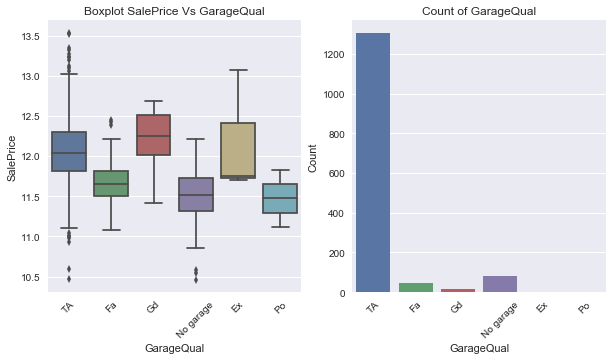

In [158]:
x="GarageQual"
categorical_analizator(x=x, y=y, data=train)

In [159]:
add_categorical.append(x)

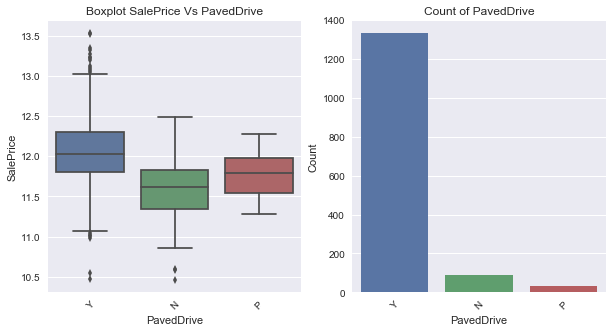

In [160]:
x="PavedDrive"
categorical_analizator(x=x, y=y, data=train)

In [161]:
add_categorical.append(x)

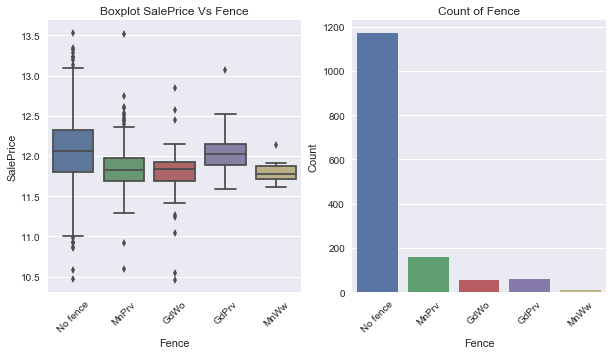

In [162]:
x="Fence"
categorical_analizator(x=x, y=y, data=train)

In [163]:
add_categorical.append(x)

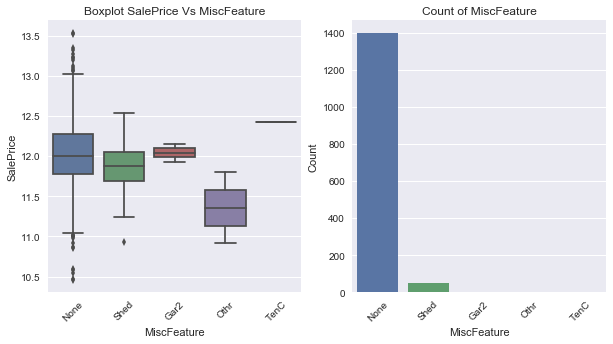

In [164]:
x="MiscFeature"
categorical_analizator(x=x, y=y, data=train)

In [165]:
add_categorical.append(x)

Although we have houses costing more than 700000, there is a concentration of houses with prices below 200000

Looking a bit closer we can see that GarageCars and GarageArea have 0.88 correlation and this is too high. GarageCars is more correlated with SalePrice than GarageArea, so maybe it's a better predictor for SalePrice. The same occurs with TotalBsmtSF and 1stFlrSF

In [ ]:
aaa

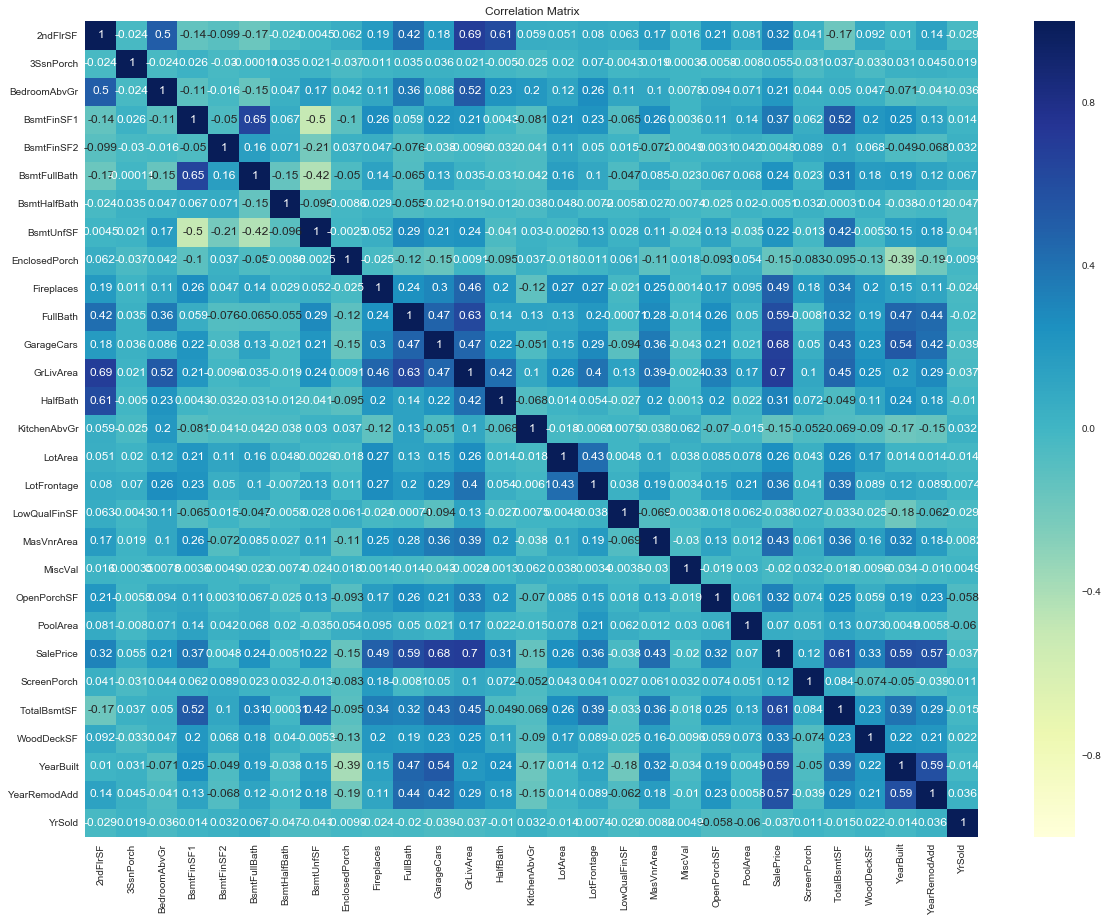

In [53]:
plt.subplots(figsize=(20,15))
sns.heatmap(train.loc[:,train.columns.difference(remove_multicolinearity)].corr(), cmap="YlGnBu", annot=True)
plt.title("Correlation Matrix")
plt.show()

In [51]:
train["MSSubClass"].unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40], dtype=int64)

Let's take a look at nulls

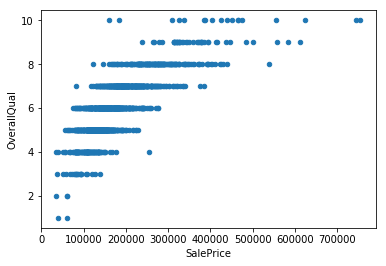

In [41]:
temp.plot(kind='scatter', x='SalePrice', y='OverallQual')

TypeError: 'str' object is not callable

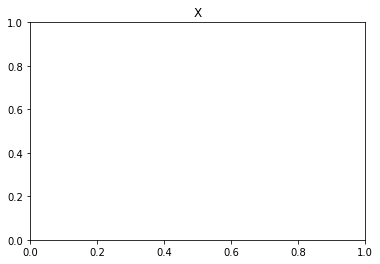

In [46]:
plt.title("X")
plt.xlabel("ASda")
plt.scatter(x=temp['SalePrice'], y=temp['OverallQual'])

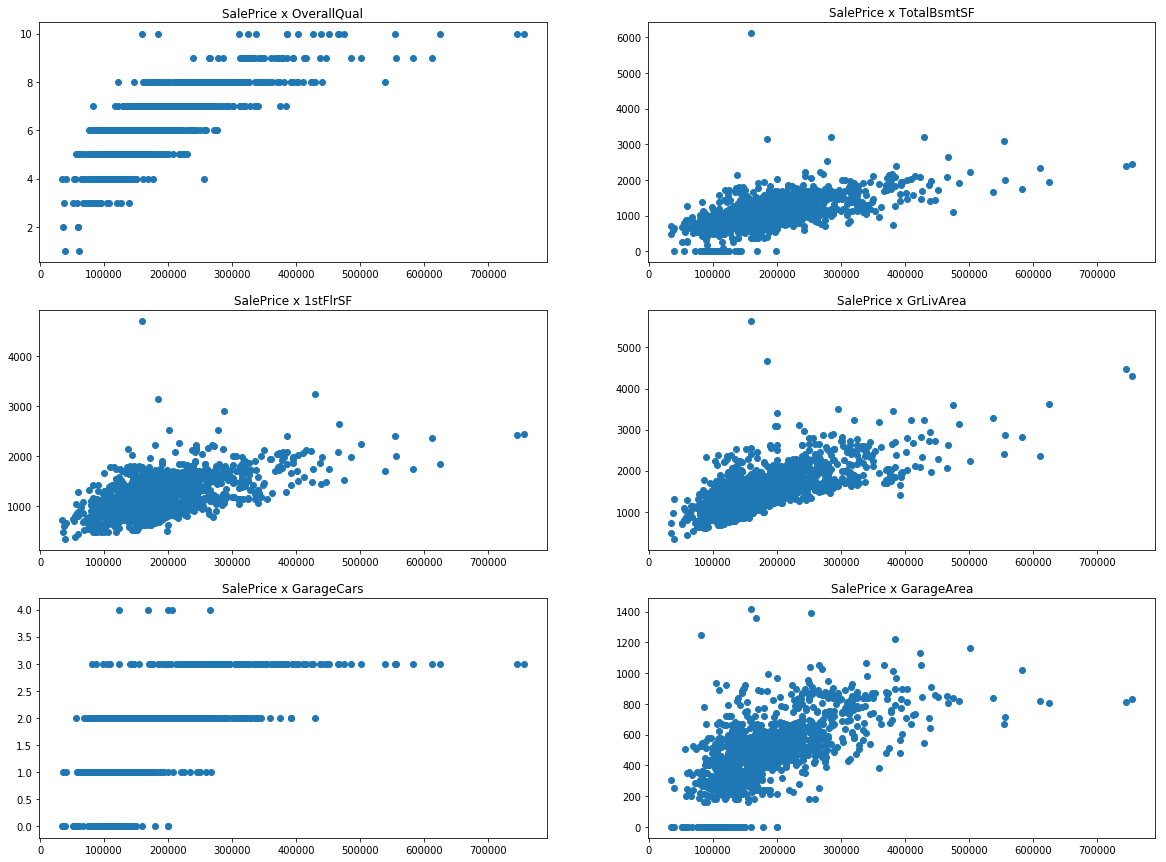

In [52]:
colunas = list(temp.columns)
colunas.remove('SalePrice')

plt.subplots(figsize=(20,15))
for n, coluna in enumerate(colunas):
    plt.subplot(3,2,n+1)
    plt.title("SalePrice x " + coluna)
    plt.scatter(x=temp['SalePrice'], y=temp[coluna])
    
plt.show()

In [ ]:
plt.subplot(321)
plt.scatter(x, y, s=80, c=z, marker=">")

plt.subplot(322)
plt.scatter(x, y, s=80, c=z, marker=(5, 0))

verts = np.array([[-1, -1], [1, -1], [1, 1], [-1, -1]])
plt.subplot(323)
plt.scatter(x, y, s=80, c=z, marker=verts)

plt.subplot(324)
plt.scatter(x, y, s=80, c=z, marker=(5, 1))

plt.subplot(325)
plt.scatter(x, y, s=80, c=z, marker='+')

plt.subplot(326)
plt.scatter(x, y, s=80, c=z, marker=(5, 2))

plt.show()